# Quantifying Weather Risk for the Citi Bike Business

Since moving to New York City, I couldn't tell you how many times I've been stranded under scaffolding for coverage without an umbrella, because I hadn't anticipated rain. While New York's fickle weather could be a nuisance for its dwellers, it poses a sizeable risk to business, especially those who are most exposed. One such example is Citi Bike, New York's public bike sharing system. 

We were curious to find out how weather could impact Citi Bike's business. In particular, our goal is figure out a way to quantify the weather risk for the Citi Bike business, simlutate certain weather scenarios to see its impact on the business, and come up with some potential ways to mitigate this risk. To do so, we set out to answer the following questions:

- What is the effect of a weather event on pass sales?
- How does the same weather event affect sales for different products, and for different consumer groups?
- What is the best/average/worse case affect of weather risk in a given time period?
- How can climate change potentially affect the business?
- How much is the business exposed to weather risk?
- What are some strategies the business should consider leveraging to minimize weather risk?

To answer these questions, we obtained weather data from the National Centers for Environmental Information, which contains daily weather measurements recorded from the Central Park station, as well as Citi Bike data from open data NYC. Many are familiar with the Citi Bike Trip Histories dataset, which contains trip level records enriched by rider information; however, for the purpose of our analysis, we looked at the Daily Ridership and Membership Data, which contains daily aggregated numbers of passes and memberships sold, as well as the number of trips and an estimated total mileage. For both datasets, we downloaded data from July 2015 to Mar 2019; though for most of our analysis, we focus on data for years 2016-2018, from January to December.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
import datetime
import feather

In [2]:
import sys
sys.path.append("/Users/yhong/Documents/scripts")
import SCM

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("/Users/yhong/Documents/data/citibike/df.csv")

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

# SCM

One would hypothesize that on a day with inclement weather, the short term (24-hour/3-day) passes would see a decrease in sales. To quantify the impact of weather events on pass sales, we use a method inspired by the [synthetic control method](https://economics.mit.edu/files/11859), which simulates a control group to compare the event affected group against. Our control features are day of the week, month, and whether or not the day is a holiday. For example, if we want to see the effect of rain on the number of 24-hour passes purchased, we would compare the number of passes purchased on days on which it rained to a simulated (weighted) group of days has the same control features on which it didn't rain. We then calculate a percentage loss, i.e. the percentage decrease in sales due to the weather event, across the aggregated rainy days portfolio with different combinations of control features. We found the following:

In [11]:
for event in ['snow', 'rain', 'fog']:
    print('\n')
    print(event+':')
    for target in ['24-Hour Passes Purchased (midnight to 11:59 pm)', '3-Day Passes Purchased (midnight to 11:59 pm)',]:
        print('    results in %s percent loss on %s.' % (round(SCM.calc_impact(df[df['Date'].dt.year.between(2016,2018)], ['month', 'weekday', 'isholiday'], event, target)*100, 2), target))



snow:
    results in 96.66 percent loss on 24-Hour Passes Purchased (midnight to 11:59 pm).
    results in 95.85 percent loss on 3-Day Passes Purchased (midnight to 11:59 pm).


rain:
    results in 58.55 percent loss on 24-Hour Passes Purchased (midnight to 11:59 pm).
    results in 58.81 percent loss on 3-Day Passes Purchased (midnight to 11:59 pm).


fog:
    results in 37.8 percent loss on 24-Hour Passes Purchased (midnight to 11:59 pm).
    results in 34.23 percent loss on 3-Day Passes Purchased (midnight to 11:59 pm).


As expected, snow affects the purchases of passes the most, at roughly 96%, followed by rain, at roughly 58%, and fog, at roughly 35%. Given the same weather event, 24-hour pass sales generally showed a slightly higher percentage loss than 3-day pass sales. It makes sense that customers may anticipate better weather conditions in the near future, and make purchase decisions accordingly.

But what about year-long subscriptions? To what extent does weather affect sales, when extended out to a year-long horizon? One would imagine that subscriptions would not be affected as much by short-term weather fluctuations. But the data show otherwise:

In [12]:
for event in ['snow', 'rain', 'fog']:
    print('\n')
    print(event+':')
    for target in ['24-Hour Passes Purchased (midnight to 11:59 pm)','membership']:
        print('    results in %s percent loss on %s.' % (round(SCM.calc_impact(df[df['Date'].dt.year.between(2016,2018)], ['month', 'weekday', 'isholiday'], event, target)*100, 2), target))



snow:
    results in 96.66 percent loss on 24-Hour Passes Purchased (midnight to 11:59 pm).
    results in 94.13 percent loss on membership.


rain:
    results in 58.55 percent loss on 24-Hour Passes Purchased (midnight to 11:59 pm).
    results in 53.73 percent loss on membership.


fog:
    results in 37.8 percent loss on 24-Hour Passes Purchased (midnight to 11:59 pm).
    results in 33.72 percent loss on membership.


In fact, we do see a decrease in membership sales conditional on each weather event, though the loss rate is slightly less than that for 24-hour sales. Though the membership lasts for a year, people still tend to purchase it more on days with better weather. We also took a look at the sales of subscriptions over time:

Text(0.5, 1.0, 'Membership Sales Timeseries')

<Figure size 432x288 with 0 Axes>

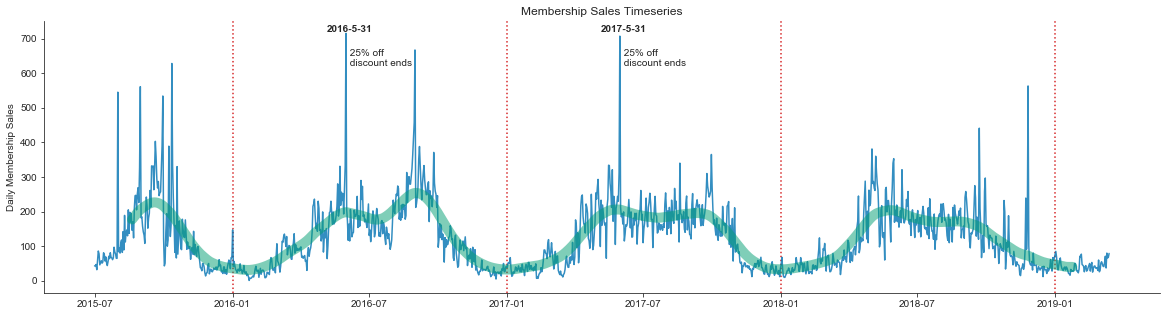

In [14]:
plt.style.use('seaborn-colorblind')
sns.set_style('ticks')
sns.despine()
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)
first = [d for d in list(df['Date']) if d.day==1 if d.month == 1 ]
for d in first:
    ax.axvline(d, color ='tab:red', linestyle = ':')
ax.plot(df['Date'], df['membership'], alpha = 0.8)
ax.plot(df['Date'], df['membership'].rolling(100, win_type='triang', center = True).mean(), linewidth = 10, alpha = 0.5, label = '')
plt.ylabel('Daily Membership Sales')
ax.text('2016-5-5', 720, "2016-5-31", fontweight = 'bold')
ax.text('2016-6-1', 620, "\n 25% off \n discount ends",)
ax.text('2017-5-5', 720, "2017-5-31", fontweight = 'bold')
ax.text('2017-6-1', 620, "\n 25% off \n discount ends",)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Membership Sales Timeseries')

We can see that the membership sales are also highly seasonal. More year-long memberships in the summer months compared to winter months. 
A brief Google search tells us that some of the bigger spikes, for instance, the one on May 31st, 2016, are on dates where Citi Bike promotions end ($25 off.) 

We can also plot the average number of purchases of passes binned by maximum temperature, wind speed, and precipitation, separated by weekday versus weekend.

In [19]:
df['TMAX_bin'] = pd.cut(df['TMAX'], np.linspace(0, 100, 11))
df['TMIN_bin'] = pd.cut(df['TMIN'], np.linspace(0, 100, 11))
df['AWND_bin'] = pd.cut(df['AWND'], [0, 2.5, 5, 10, 20])
df['PRCP_bin'] = pd.cut(df['PRCP'], [0,0.02, 0.05, 0.1, 0.25, 0.5, 3.5])
df['SNOW_bin'] = pd.cut(df['SNOW'], [0,2,30])

Text(0.5, 1.0, 'Trip Count Binned by Max Temperature')

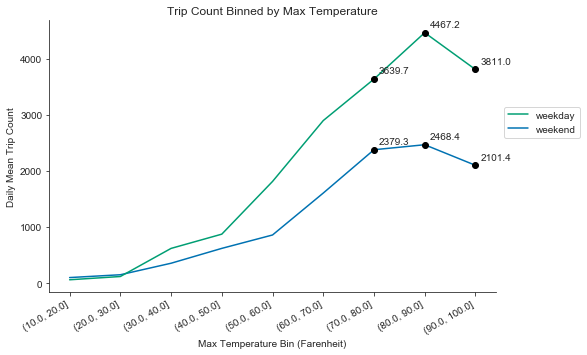

In [17]:
grp = df.groupby(['isweekend', 'TMAX_bin'])['24-Hour Passes Purchased (midnight to 11:59 pm)'].mean().reset_index().pivot_table(index = 'TMAX_bin', columns = 'isweekend', values = '24-Hour Passes Purchased (midnight to 11:59 pm)')
ax = grp.plot(kind = 'line', figsize = (8, 5), grid = True, legend = 'reverse')
ax.set_xticks(range(grp.shape[0]))
ax.set_xticklabels(grp.index,rotation = 30, ha = 'right')
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), ['weekday', 'weekend'],bbox_to_anchor=(1.2, 0.7))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Daily Mean Trip Count')
plt.xlabel('Max Temperature Bin (Farenheit)')
for n in [0, 1]:
    for idx, (i,j) in enumerate(grp[n].items()):
        if idx >5:
            ax.annotate(str(round(j,1)), xy=(idx+0.1, j+100))
            ax.plot(idx, j, 'ko') 
plt.title('Trip Count Binned by Max Temperature')

Text(0.5, 1.0, 'Trip Count Binned by Windspeed')

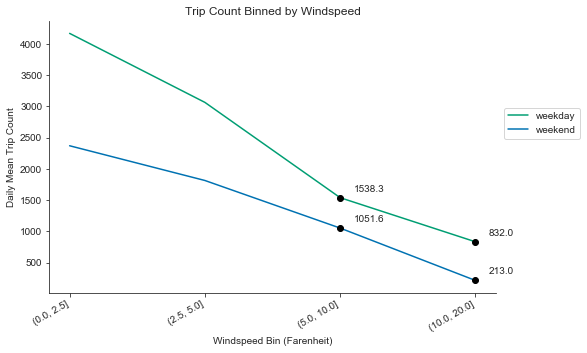

In [20]:
grp = df.groupby(['isweekend', 'AWND_bin'])['24-Hour Passes Purchased (midnight to 11:59 pm)'].mean().reset_index().pivot_table(index = 'AWND_bin', columns = 'isweekend', values = '24-Hour Passes Purchased (midnight to 11:59 pm)')
ax = grp.plot(kind = 'line', figsize = (8, 5), grid = True, legend = 'reverse')
ax.set_xticks(range(grp.shape[0]))
ax.set_xticklabels(grp.index,rotation = 30, ha = 'right')
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), ['weekday', 'weekend'],bbox_to_anchor=(1.2, 0.7))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Daily Mean Trip Count')
plt.xlabel('Windspeed Bin (Farenheit)')
for n in [0, 1]:
    for idx, (i,j) in enumerate(grp[n].items()):
        if idx >1:
            ax.annotate(str(round(j,1)), xy=(idx+0.1, j+100))
            ax.plot(idx, j, 'ko') 
plt.title('Trip Count Binned by Windspeed')

Text(0.5, 1.0, 'Trip Count Binned by Precipitation')

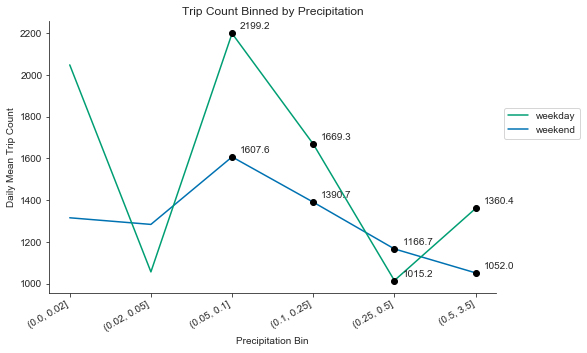

In [23]:
grp = df.groupby(['isweekend', 'PRCP_bin'])['24-Hour Passes Purchased (midnight to 11:59 pm)'].mean().reset_index().pivot_table(index = 'PRCP_bin', columns = 'isweekend', values = '24-Hour Passes Purchased (midnight to 11:59 pm)')
ax = grp.plot(kind = 'line', figsize = (8, 5), grid = True, legend = 'reverse')
ax.set_xticks(range(grp.shape[0]))
ax.set_xticklabels(grp.index,rotation = 30, ha = 'right')
ax.grid(False)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), ['weekday', 'weekend'],bbox_to_anchor=(1.2, 0.7))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('Daily Mean Trip Count')
plt.xlabel('Precipitation Bin')
for n in [0, 1]:
    for idx, (i,j) in enumerate(grp[n].items()):
        if idx >1:
            ax.annotate(str(round(j,1)), xy=(idx+0.1, j+20))
            ax.plot(idx, j, 'ko') 
plt.title('Trip Count Binned by Precipitation')

As we can see, the relationship between temperature and 24-hour passes purchased is an interesting non-linear one; notice how the curve flattens then drops as it gets too hot to bike. On the other hand, the relationship between windspeed and sales is a monotonic one; as windspeed increases, 24-hour passes sales decrease. However, given that it rains, the relationship between precipitation and sales is rather unclear; there is no indication that higher precipitation corresponds to lower sales.

Given our framework, we can also investigate the impact of weather events on the total number of trips. We used the trips dataset to obtain the number of trips by user type and gender.

In [24]:
for event in ['snow', 'rain', 'fog']:
    print('\n')
    print(event+':')
    for target in ['Customer', 'Subscriber']:
        print('    results in %s percent loss on %s trips.' % (round(SCM.calc_impact(df[df['Date'].dt.year.between(2016,2018)], ['month', 'weekday', 'isholiday'], event, target)*100, 2), target))



snow:
    results in 96.31 percent loss on Customer trips.
    results in 93.19 percent loss on Subscriber trips.


rain:
    results in 60.32 percent loss on Customer trips.
    results in 53.65 percent loss on Subscriber trips.


fog:
    results in 39.4 percent loss on Customer trips.
    results in 35.82 percent loss on Subscriber trips.


As we see here, given the same weather, customer trips (those with 24-hour or 3-day passes) are more affected than subscriber trips (those with year-long memberships).

In [25]:
for event in ['snow', 'rain', 'fog']:
    print('\n')
    print(event+':')
    for target in ['female', 'male']:
        print('    results in %s percent loss on %s trips.' % (round(SCM.calc_impact(df[df['Date'].dt.year.between(2016,2018)], ['month', 'weekday', 'isholiday'], event, target)*100, 2), target))



snow:
    results in 93.68 percent loss on female trips.
    results in 93.09 percent loss on male trips.


rain:
    results in 54.85 percent loss on female trips.
    results in 53.26 percent loss on male trips.


fog:
    results in 36.3 percent loss on female trips.
    results in 35.58 percent loss on male trips.


And trips made by females are slightly more affected by weather than those made by males. 
This may imply that women are more risk averse when it comes to biking in inclement weather, which confirms the findings in this [study](https://www.sciencedirect.com/science/article/abs/pii/S0966692318306045). 

What the data reveals about consumer behavior is highly interesting. While promotions can be strong incentives for membership sales, weather and seasonality can influence buying decisions, even when they shouldn't factor into the consumer's weather risk calculation when considering their ability to maximize ridership across a year-long horizon. 

There are a few possible explanations here. Indeed, the consumer may only be considering the weather conditions and ability to ride for the time period immediately following their membership purchase, and fail to anticipate a longer horizon ahead. Perhaps the consumer has an urgent but not temporary need for a bike, but shorter-term passes are impractical for their concerns. It is also likely that the consumer intends to use their membership as a seasonal pass; they may be temporarily in the city, or plan to only ride during times with nicer weather, thus while they have taken into account the fact that they won't be riding as much when the weather is less pleasant, they are happy with paying for the entire year for effectively not using the membership to its full capacity. There could also be other sales-influencing variables, such as promotions, events, etc., that skew towards days/seasons with nicer weather; it would be interesting to do this analysis conditionally on those variables.

# Random forest model

So far, we've established that single weather events can be a strong predictor for Citi Bike pass sales. We also discovered that certain weather variables, such as TMAX, exhibit a non-linear relationship with pass sales. To further explore the interactions between different variables and build a model to predict pass sales, we will build a random forest model. 

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [27]:
df['days_since_start'] = df.index

We begin by choosing choosing a wide range of time and weather features that are potentially predictive of 24-hour pass sales, fitting a model, and exploring the feature importance (code omitted here). We then iteratively build new models, starting from the most important several features, adding one new feature at a time, and compare the incremental change in the train and test performance based on the R^2 score. Through this process, we determined that the following features are the ones that we should include in our model:

In [32]:
features = ['TMAX', 'days_since_start', 'weekday', 'PRCP', 'month', 'AWND', 'SNWD', 'fog', 'TMIN','isholiday',  ]
train = []
test = []
for i in range(len(features)):
    cols = features[:i+1]
    print(i, cols[-1])
    imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value = 0)
    imp.fit(df[cols])  
    tdf = imp.transform(df[cols])
    
    X, y = tdf, df['Trips over the past 24-hours (midnight to 11:59pm)']
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle = False)
    
    reg = RandomForestRegressor( n_jobs = -1)
    reg.fit(X_train, y_train)
    
    print(reg.score(X_train, y_train), reg.score(X_test, y_test))
    train.append(reg.score(X_train, y_train))
    test.append(reg.score(X_test, y_test))


    

0 TMAX
0.5519839464944509 0.16846375906802802
1 days_since_start
0.9509400183580852 0.2655717113876368
2 weekday
0.9521999852889357 0.45108849555987696
3 PRCP
0.9747168784213057 0.7118035301279433
4 month
0.9764963203178398 0.6296807129007607
5 AWND
0.9751576173350978 0.693674331222302
6 SNWD
0.9766188100472112 0.6925321913392
7 fog
0.9760328197481255 0.6359248295822083
8 TMIN
0.9765833251106243 0.6891427959758383
9 isholiday
0.9761823273190443 0.7042993635245078


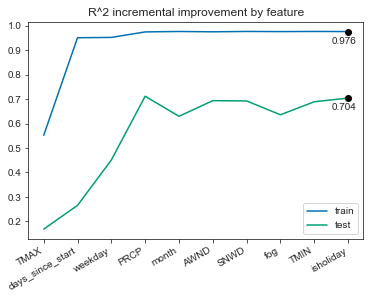

In [33]:
plt.figure(figsize = (6,4))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.xticks(np.arange(len(features)), features, rotation = 30, ha = 'right')
plt.title('R^2 incremental improvement by feature')

plt.annotate(str(np.round(train[-1],3)), xy=(len(features)-1.5, train[-1]-0.05))
plt.plot(len(features)-1, train[-1], 'ko') 
plt.annotate(str(np.round(test[-1],3)), xy=(len(features)-1.5, test[-1]-0.05))
plt.plot(len(features)-1, test[-1], 'ko') 
plt.legend()

We then do a grid search to determine the best hyperparameters for our model. Using the resulting hyperparameters of the grid search, we finalize our predictive model. 

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 25, num = 15)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor(n_jobs=-1,)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 5760 candidates, totalling 11520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

{'bootstrap': True,
 'max_depth': 14,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 127}

In [121]:
grid_search.best_score_

0.7045854077411042

In [114]:
rg = RandomForestRegressor(n_jobs=-1,bootstrap = True,
 max_depth = 14,
 max_features = 'auto',
 min_samples_leaf = 2,
 min_samples_split = 5,
 n_estimators = 127)
rg.fit(X_train, y_train)
print(rg.score(X_train, y_train), rg.score(X_test, y_test))

0.9704098408909801 0.7333926578676793


Our final model has an in-sample R^2 of 0.970, and an out of sample R^2 of 0.733.

Finally, to get a sense of how each feature affects the dependent variable, we ran a linear regression on normalized features, and obtained each corresponding coefficient.

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(df[cols+['Trips over the past 24-hours (midnight to 11:59pm)']])  
nsc = scaler.transform(df[cols+['Trips over the past 24-hours (midnight to 11:59pm)']])

In [39]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(nsc)  
sc = imp.transform(nsc)

In [40]:
X_n, y_n = sc[:, 0:10], sc[:, -1]
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X_n, y_n, test_size=0.2, shuffle = False)

In [122]:
normreg = LinearRegression().fit(X_train_n, y_train_n)

Text(0.5, 1.0, 'Signed feature importance \n according to normalized regression')

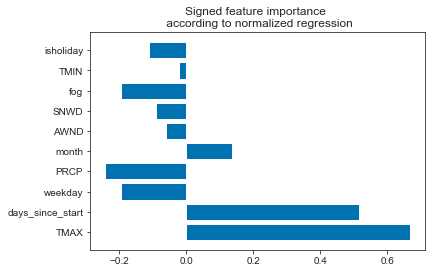

In [123]:
plt.figure(figsize = (6,4))
plt.barh(cols, normreg.coef_)
plt.title('Signed feature importance \n according to normalized regression')

The plot above shows that 'TMAX', the maximum temperature, has the largest positive predictive power on 24-hour pass sales. The fact that days_since_start is a positive predictive feature suggests that 24-hour pass sales has been growing over time. Also notice that inclement weather indicators, such as fog, and weather variables, such as 'PRCP'(precipitation), 'SNWD' (snow depth), and 'AWND' (windspeed), have negative predictive effects on 24-hour pass sales, as expected.

# Data simulation

Given our predictive model, we can ask questions about data based on hypothetical scenarios of interests. For example, if it had rained on every day in the month of July in 2018, how would 24-hour pass sales be impacted? Similarly, if it were sunny every day in that month, how many passes could have hypothetically been sold? In this way, we could run our predictive model on simulated data to get an estimate on the best and worse case scenarios for pass sales. Let's take a look.

In [124]:
july = df[(df['Date'].dt.year==2018)&(df['Date'].dt.month==7)][cols].fillna(0).copy()
july_actual = july.values
july['PRCP'] = max(july['PRCP'])
july_max = july.values
july['PRCP'] = 0
july_min = july.values
july_actual = df[(df['Date'].dt.year==2018)&(df['Date'].dt.month==7)]['Trips over the past 24-hours (midnight to 11:59pm)'].values

Here, we looked at the month of July 2018. We simulated the worse case - rainy day every day - for this month by changing the precipitation variable to the maximum value of that month, and simulated the best case by setting precipitation to 0 for each day. We then plotted the predicted 24-hour pass sales according to our model's predictions, compared with the actual sales.

Text(0.5, 1.0, 'Jul. 2018 \n Best/worst case of sales based on simulated weather data')

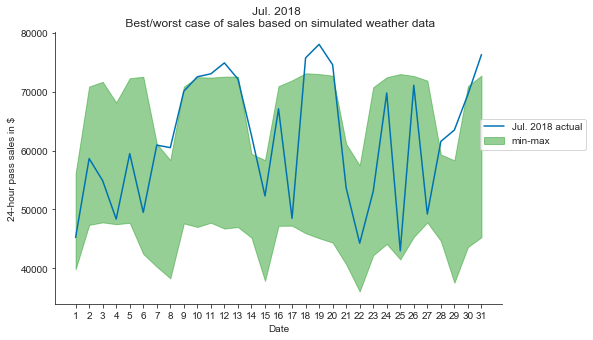

In [139]:
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)
ax.plot(np.arange(1, 32, 1.0), july_actual, label = 'Jul. 2018 actual')
#ax.plot(np.arange(31), rg.predict(july_actual), label = 'predicted', color = 'gray', alpha = 0.5)
plt.fill_between(np.arange(1, 32, 1.0), rg.predict(july_max), rg.predict(july_min), alpha = 0.5, color = 'tab:green', label = 'min-max')
ax.legend(bbox_to_anchor=(1.2, 0.7))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(np.arange(1, 32, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('24-hour pass sales in $')
plt.xlabel('Date')
plt.title('Jul. 2018 \n Best/worst case of sales based on simulated weather data')
#plt.savefig("/Users/yhong/Documents/data/citibike/plots/min-max.png", bbox_inches = 'tight')

In [129]:
print('Best: $',sum(rg.predict(july_min)))
print('Worst: $',sum(rg.predict(july_max)), '('+str(sum(rg.predict(july_max)) - sum(rg.predict(july_min)))+')')
print('Actual: $', sum(july_actual), '('+str(sum(july_actual)- sum(rg.predict(july_min)))+')')


Best: $ 2111558.9110485404
Worst: $ 1369726.3803055866 (-741832.5307429538)
Actual: $ 1913557 (-198001.91104854038)


According to our model, in the best case scenario, the sales for the month could have been 2,111,559 dollars, whereas in the worse case scenario, the sales could have been 1,369,726 dollars. The actual sales were 1,913,557 dollars, and we estimate a loss of 198,001 dollars due to rain.

Next, we wanted to perform a similar estimation for the month of July 2019 in the near future, in which we will predict the monthly sales using simulated weather data based on the precipitation we have for the same month in the past 3 years. We obtained the average case by taking an average of the precipitation data for each day in the past 3 July's, the worst case by taking the highest precipitation value observed in the past 3 July's, and the best case by setting precipitation to 0 for each day of the month. The date and time features were adjusted accordingly.


In [55]:
jul2016 = df[(df['Date'].dt.year==2016)&(df['Date'].dt.month==7)]['PRCP'].fillna(0).reset_index()
jul2017 = df[(df['Date'].dt.year==2017)&(df['Date'].dt.month==7)]['PRCP'].fillna(0).reset_index()
jul2018 = df[(df['Date'].dt.year==2018)&(df['Date'].dt.month==7)]['PRCP'].fillna(0).reset_index()
jul_avg = (jul2016+jul2017+jul2018)/3  

In [56]:
july = df[(df['Date'].dt.year==2018)&(df['Date'].dt.month==7)][cols].fillna(0).copy()
july2019 = july.copy()
july2019['days_since_start'] = july2019['days_since_start']+365
july2019['weekday'] = (july2019['weekday']+1) % 7
july2019_avg = july2019.copy()
july2019_avg['PRCP'] = jul_avg['PRCP'].values
july2019_min = july2019.copy()
july2019_min['PRCP'] = 0
july2019_max = july2019.copy()
july2019_max['PRCP'] = max(max(jul2016['PRCP']), max(jul2017['PRCP']), max(jul2018['PRCP']))

Text(0.5, 0, 'Date')

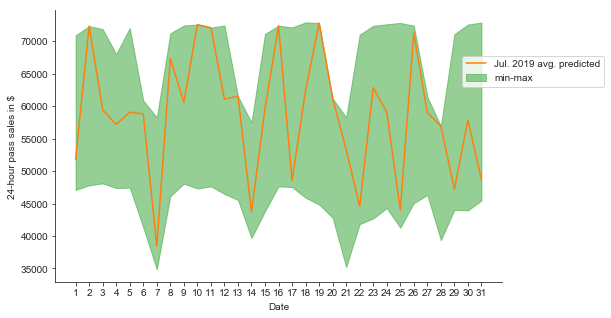

In [140]:
sns.set_style('ticks')
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)
ax.plot(np.arange(1, 32, 1.0), rg.predict(july2019_avg), label = 'Jul. 2019 avg. predicted', color = 'tab:orange')
plt.fill_between(np.arange(1, 32, 1.0), rg.predict(july2019_max), rg.predict(july2019_min), alpha = 0.5, color = 'tab:green', label = 'min-max')
ax.legend(bbox_to_anchor=(0.9, 0.7))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xticks(np.arange(1, 32, 1.0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('24-hour pass sales in $')
plt.xlabel('Date')
#plt.title('Jul. 2019 \n Best/worst case of sales based on simulated weather data')

In [131]:
print('Best: $',sum(rg.predict(july2019_min)))
print('Worst: $',sum(rg.predict(july2019_max)), '('+str(sum(rg.predict(july2019_max)) - sum(rg.predict(july2019_min)))+')')
print('Average: $', sum(rg.predict(july2019_avg)), '('+str(sum(rg.predict(july2019_avg))- sum(rg.predict(july2019_min)))+')')


Best: $ 2131177.789941081
Worst: $ 1376931.751555203 (-754246.0383858779)
Average: $ 1817764.0375750833 (-313413.7523659975)


According to our model, in the best case scenario, the sales for July 2019 could be 2,131,177 dollars, whereas in the worse case scenario, the sales could be 1,376,931 dollars. The average case sales is 1,817,764 dollars.

We were also curious about the potential impact of climate change on the business. Equipped with our predictive model, we can ask the folliwing question: if the minimum and maximum temperature increased by 10 degress Fahrenheit for a given month, how would 24-hour pass sales be impacted? We know from our previous maximum temperature sales curve that once the temperature reaches a certain height, pass sales would see a decrease. With our predictive model, we can estimated the effect with simulated data constructed from our hypothetical scenario.

We took the month with the hottest average temperature - August of 2015, and made each day 10 degress Fahrenheit hotter. 

In [107]:
aug = df[(df['Date'].dt.year==2015)&(df['Date'].dt.month==8)][cols].fillna(0).copy()
aug_temp = df[(df['Date'].dt.year==2015)&(df['Date'].dt.month==8)][cols].fillna(0).copy()
aug_temp['TMIN'] +=10
aug_temp['TMAX'] +=10

In [111]:
aug_actual = df[(df['Date'].dt.year==2015)&(df['Date'].dt.month==8)]['Trips over the past 24-hours (midnight to 11:59pm)'].values

We then plotted the actual sales, predicted sales according to our model, and the predicted sales in the hypothetical scenario.

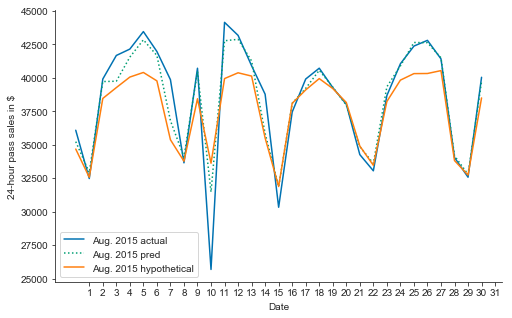

In [141]:
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot(111)
plt.plot(np.arange(31), aug_actual, label = 'Aug. 2015 actual', )
plt.plot(np.arange(31), rg.predict(aug), label = 'Aug. 2015 pred', linestyle = ":")
plt.plot(np.arange(31), rg.predict(aug_temp), label = 'Aug. 2015 hypothetical', color = 'tab:orange')
plt.ylabel('24-hour pass sales in $')
plt.xlabel('Date')
plt.xticks(np.arange(1, 32, 1.0))
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend()

In [132]:
print('Actual: $', sum(aug_actual))
print('Predicted: $', sum(rg.predict(aug)), '('+str(sum(rg.predict(aug)) - sum(aug_actual))+')')
print('Hypothetical (10 degrees hotter): $', sum(rg.predict(aug_temp)), '('+str(sum(rg.predict(aug_temp)) - sum(aug_actual))+')')

Actual: $ 1190704
Predicted: $ 1188500.0565669462 (-2203.9434330537915)
Hypothetical (10 degrees hotter): $ 1161504.6290611625 (-29199.37093883753)


Our model predicted that the sales of August 2015 would be 1,188,500 dollars, which is 99.8% that of the actual sales, at 1,190,704 dollars. If due to climate change, the minimum and maximum temperatures increased by 10 degrees Fahrenheit in that month, the sales would decrease by 29,199 dollars, according to our model.

# Active Ridership Analysis

Citi Bike memberships expire in a year. 24-hour and 3-day passes last for one day and three days respectively, by definition. We were curious to see how different customer groups were taking advantage of their ride passes. For this, we came up with the concept of "active ridership", which is the number of membership or pass holders with active (unexpired) riding passes. We obtained these numbers by subtracting out sales that occurred before the expiration length for each product. 

In [142]:
df['total active subscriber'] = df['Total Annual Memberships Sold'].shift(periods=365)
df['total active subscriber'] = df['Total Annual Memberships Sold'] - df['total active subscriber']

In [143]:
df['total active customer'] = df['3-Day Passes Purchased (midnight to 11:59 pm)'].rolling(3).sum()
df['total active customer'] += df['24-Hour Passes Purchased (midnight to 11:59 pm)']

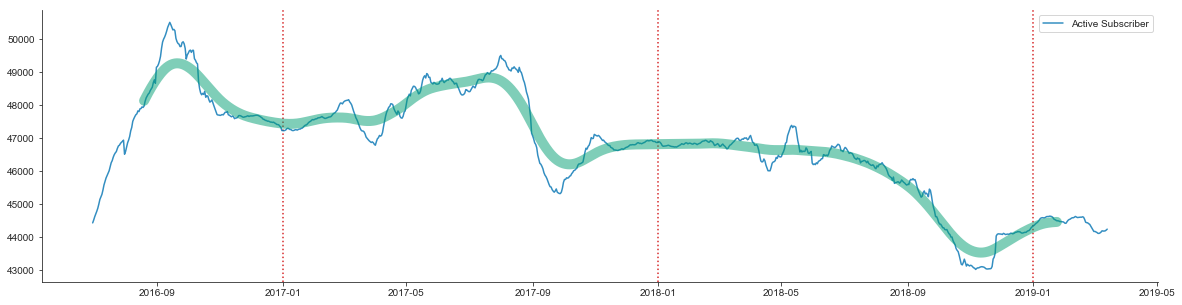

In [144]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)
first = [d for d in list(df['Date']) if d.day==1 if d.month == 1 if d.year >2016]
for d in first:
    ax.axvline(d, color ='tab:red', linestyle = ':')
ax.plot(df['Date'], df['total active subscriber'] , label = 'Active Subscriber', alpha = 0.8)
ax.plot(df['Date'], df['total active subscriber'].rolling(100, win_type='triang', center = True).mean(), linewidth = 10, alpha = 0.5, label = '')
ax.legend()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

A somewhat surprising discovery is that the number of active membership holders has gone down from September 2016 to April 2019 by about 10%. Active ridership was at its peak in late 2016, and has decreased gradually since, showing no observable seasonal effects. The biggest drops tend to happen during the fall, when presumably riders fail to renew their memberships in anticipation of decreased usage in cold weather or during the next year.

On the other hand, active holders of short term passes exbihit strong seasonality and variability, and has increased over time.

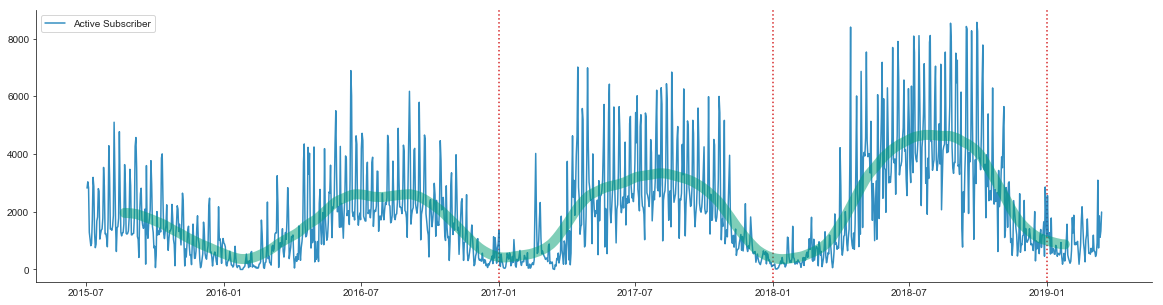

In [151]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)
first = [d for d in list(df['Date']) if d.day==1 if d.month == 1 if d.year >2016]
for d in first:
    ax.axvline(d, color ='tab:red', linestyle = ':')
ax.plot(df['Date'], df['total active customer'] , label = 'Active Subscriber', alpha = 0.8)
ax.plot(df['Date'], df['total active customer'].rolling(100, win_type='triang', center = True).mean(), linewidth = 10, alpha = 0.5, label = '')
ax.legend()
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

We also wanted to see how riders used their riding passes based on time of year and product type. So we merged our data with the Citi Bike trips dataset, from which we took an aggregate number of trips per day, grouped by customer type. We then calculated the number of trips per active riding pass, and plotted the time series. 

In [152]:
df['trip per active subscriber'] = df['Subscriber']/df['total active subscriber']
df['trip per active customer'] = df['Customer']/df['total active customer']

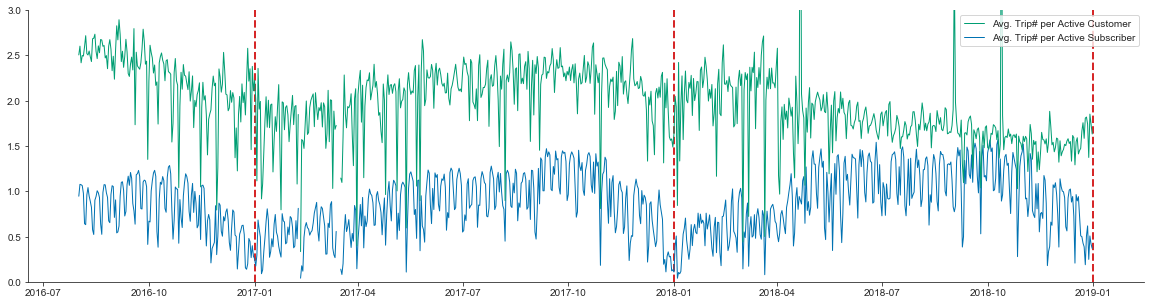

In [153]:
fig = plt.figure(figsize = (20,5))
ax = fig.add_subplot(111)
first = [d for d in list(df['Date']) if d.day==1 if d.month == 1 if d.year >2016]
for d in first:
    ax.axvline(d, color ='tab:red', linestyle = '--', linewidth = 2)
ax.plot(df[df['Date']>datetime.date(2016,7,31)]['Date'], df[df['Date']>datetime.date(2016,7,31)]['trip per active subscriber'] , label = 'Avg. Trip# per Active Subscriber', linewidth=1)
ax.plot(df[df['Date']>datetime.date(2016,7,31)]['Date'], df[df['Date']>datetime.date(2016,7,31)]['trip per active customer'] , label = 'Avg. Trip# per Active Customer', linewidth=1)
plt.ylim((0, 3))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

We can see that "Customers" (i.e. 24-hour/3-day pass holders) on average took more daily trips than "Subsribers" (i.e. membership holders), meaning that short term pass holders generally took better advantage of their riding passes than membership holders. Trips per active membership exhibited strong seasonality, while trips per active short-term pass remained roughly constant with a slight decrease, and has a larger variance, presumably due to weather influences, as we have discussed.

# Conclusion

We set out to quantify the weather risk for the Citi Bike business. Combining weather data and pass sales, we were able to estimate the impact of inclement weather on pass sales, as well as trends and aggregate affects of weather variables on pass sales, using statistical methods, predictive modeling, and data simulation. We also analyzed rider behavior segmented by different consumer groups, which gave us insight on how sensitive different consumer groups are to seasonality effects and weather variability. Our results have shown that short-term pass sales are more vulnerable to weather risk.

In [154]:
df['24-Hour $'] = df['24-Hour Passes Purchased (midnight to 11:59 pm)']*12
df['3-Day $'] = df['3-Day Passes Purchased (midnight to 11:59 pm)']*24
df['membership $'] = df['membership']*169

Using data on pass sales and pass prices, we can calculate the distribution of sales in dollars among products over time. We can see that from July 2015 to April 2019, the proportion of sales in dollars from short-term passes has steadily increased, from 45.1% to 59.1%. Coupled with our previous results, this indicates that Citi Bike's exposure to weather risk has also increased. Hence the Citi Business as a whole is becoming more vulnerable to weather risk.

In [157]:
grp = df[['Date', '24-Hour $', '3-Day $', 'membership $']].set_index('Date')
grp_month = grp.reset_index()
grp_month['year'] = grp_month['Date'].dt.year
grp_month['half'] = np.where(grp_month['Date'].dt.month<7, 1, 7)
grp_month = grp_month.groupby(['year', 'half'])['24-Hour $', '3-Day $', 'membership $'].sum().reset_index()
grp_month['datetime'] = grp_month.apply(lambda x: datetime.date(int(x['year']), int(x['half']), 1), axis = 1)
grp_month = grp_month.set_index('datetime')

Text(0.5, 1.0, 'Sales $ distribution over time')

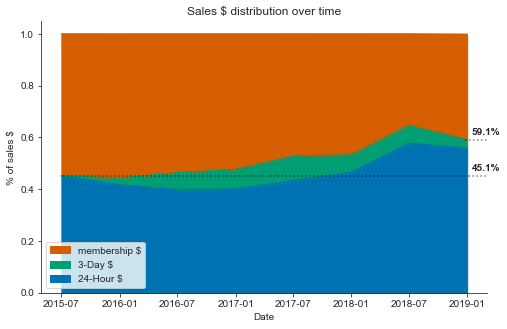

In [158]:
grp_month_perc = grp_month[['24-Hour $', '3-Day $', 'membership $']].divide(grp_month.sum(axis=1), axis=0)
ax = grp_month_perc[['24-Hour $', '3-Day $', 'membership $']].plot(kind = 'area', stacked = True, figsize = (8, 5), legend = 'reverse')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(0.558339+0.032212, xmin=0.95, linestyle = ':', color = 'k', alpha = 0.5)
ax.axhline(0.451281, xmin=0.05, linestyle = ':', color = 'k', alpha = 0.5)
ax.text('2019-1-15', 0.558339+0.032212+0.02, str(round(0.558339*100+0.032212*100, 1))+'%', fontweight = 'bold')
ax.text('2019-1-15', 0.451281+0.02, str(round(0.451281*100, 1))+'%', fontweight = 'bold')
plt.ylabel('% of sales $')
plt.xlabel('Date')
plt.title('Sales $ distribution over time')

Given this conclusion, our call to action is the following: Citi Bike should consider hedging its weather risk exposure. To do so, Citi Bike can develop weather based pricing schemas for both its customer and subscriber products. Using weather based predictive models and supply-demand based price sensitivity curves, Citi Bike can adjust pass pricing to maximize profitability. It can also estimate and incorporate average weather risk into membership pricing. 

Additionally, Citi Bike may also consider introducing new products with different expiration lengths, such as monthly or seasonal passes, based on weather predictions and seasonality. This will attract consumers who are aware of and/or especially affected by weather risk, such as women (as we have shown previously), low-income groups, and temporary residents. Of course, to determine what may be the most suitable product to introduce, more market research and data on new and existing consumer group preferences is needed.

